In [2]:
import xlrd
import numpy as np
import matplotlib.pylab as plt
import altair as alt

# Donnée météorologiques RT2012

documentation à propos des données: https://www.rt-batiment.fr/batiments-neufs/reglementation-thermique-2012/donnees-meteorologiques.html

In [3]:
filename = './FichiersMeteo_RT2012.xls'
weather_data = xlrd.open_workbook(filename)

In [4]:
print('sheets:', ', '.join(weather_data.sheet_names()))

sheets: Descriptif, H1a, H1b, H1c, H2a, H2b, H2c, H2d, H3


In [5]:
descriptif = weather_data.sheet_by_name('Descriptif')

print('Descriptif')
print('==========')
for row in descriptif.get_rows():
    r = [r.value for r in row]
    print('\t'.join(r))

Descriptif
Zone climatique	Ville	
H1a	Trappes	
H1b	Nancy	
H1c	Macon	
H2a	Rennes	
H2b	La Rochelle	
H2c	Agen	
H2d	Carpentras	
H3	Nice	
		
Variable	Unité	Libellé
Htsmd	s.o.	Heure de début de pas de temps en UTC
te0 (°C)	°C	Température extérieure
we0 (g/kg)	g/kg	Poids d'eau au niveau de la mer
dirN (W/m²)	W/m²	Rayonnement direct normal au rayonnement solaire
diff (W/m²)	W/m²	Rayonnement diffus horizontal
Teciel (°C)	°C	Température du ciel
Vent (m/s)	m/s	Vitesse du vent
Teau (°C)	°C	Température d'eau alimentant la production d'ECS à l'altitude 0 m
Gamma (°)	°	Hauteur du soleil
Psi (°)	°	Orientation du soleil par rapport au sud (lever négatif)


In [6]:
villes = {'H1a': 'Trappes',
          'H1b': 'Nancy',
          'H1c': 'Macon',
          'H2a': 'Rennes',
          'H2b': 'La Rochelle',
          'H2c': 'Agen',
          'H2d': 'Carpentras',
          'H3' : 'Nice'}

In [7]:
k = 0
zc = list(villes.keys())

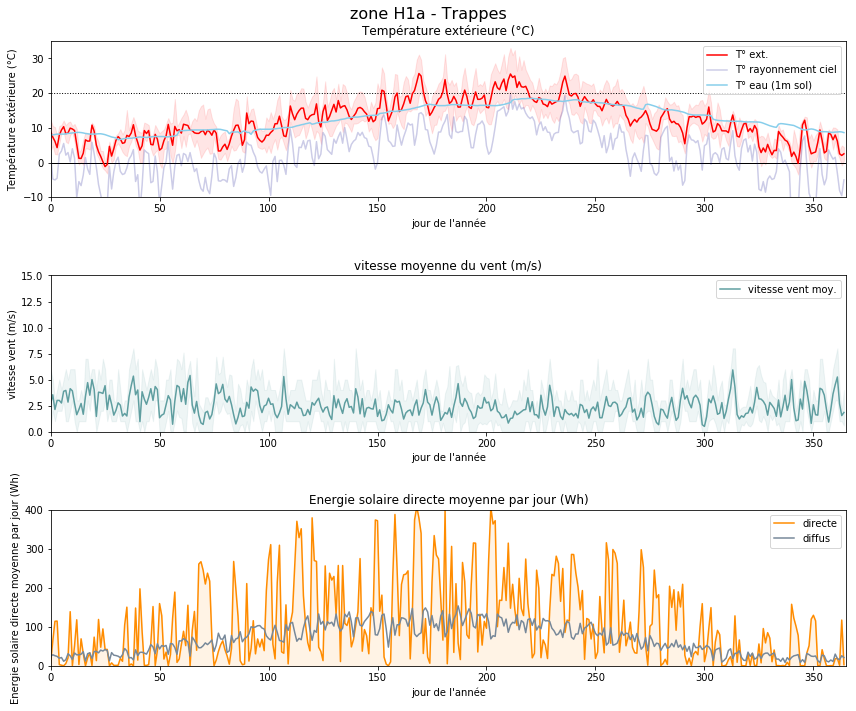

In [8]:
zone_climatique = 'H1a'
#zone_climatique = zc[k]
#print(k, zone_climatique)
#k += 1

# Reads columns
variables = ['Htsmd', 'te0', 'we0', 'dirN', 'diff', 'Teciel', 'Vent', 'Teau', 'Gamma', 'Psi']
datazone = weather_data.sheet_by_name(zone_climatique)
data = {var:np.array([cell.value for cell in datazone.col(c, start_rowx=1)])
        for c, var in enumerate(variables)}

fig = plt.figure(figsize=(12, 10))
nbr_graph = 3

# === Temperature ===
ax1 = plt.subplot(nbr_graph, 1, 1)

T_ext_grid = data['te0'].reshape(-1, 24).T
T_ciel_grid = data['Teciel'].reshape(-1, 24).T
T_eau_grid = data['Teau'].reshape(-1, 24).T

plt.axhline(y=0, linewidth=1, color='black');
plt.axhline(y=20, linewidth=1, linestyle=':', color='black');

# T_ext
plt.plot(T_ext_grid.mean(axis=0), color='r', label='T° ext.')
x = np.arange(T_ext_grid.shape[1])
plt.fill_between(x, T_ext_grid.min(axis=0), T_ext_grid.max(axis=0), color='red', alpha=0.1);

# T_ciel
#plt.plot(T_ciel_grid.max(axis=0), color='skyblue', label='T° eau (1m sol)')
plt.plot(T_ciel_grid.mean(axis=0), color='darkblue', label='T° rayonnement ciel', alpha=0.2)
#plt.plot(T_ciel_grid.min(axis=0), color='skyblue', label='T° eau (1m sol)')

# T_eau
plt.plot(T_eau_grid.mean(axis=0), color='skyblue', label='T° eau (1m sol)')

plt.xlim(0, T_ext_grid.shape[1]); #plt.title("Température extérieure (°C)");
plt.ylabel("Température extérieure (°C)");
plt.legend(); plt.xlabel("jour de l'année");
plt.title("Température extérieure (°C)");
plt.ylim((-10, 35))

# === Vent ===
ax1 = plt.subplot(nbr_graph, 1, 2, sharex=ax1)
vent_grid = data['Vent'].reshape(-1, 24).T

plt.plot(vent_grid.mean(axis=0), color='cadetblue', label='vitesse vent moy.')
x = np.arange(T_ext_grid.shape[1])
plt.fill_between(x, vent_grid.min(axis=0), vent_grid.max(axis=0), color='cadetblue', alpha=0.1);

plt.xlim(0, T_ext_grid.shape[1]); plt.title("vitesse moyenne du vent (m/s)");
plt.ylabel("vitesse vent (m/s)"); plt.xlabel("jour de l'année");
plt.legend();
plt.ylim((0, 15))

# === Soleil ===
ax2 = plt.subplot(nbr_graph, 1, 3, sharex=ax1)
ax2.set_title(f'{zone_climatique} {villes[zone_climatique]}')

dirN_grid = data['dirN'].reshape(-1, 24).T
diff_grid = data['diff'].reshape(-1, 24).T
plt.plot(dirN_grid.sum(axis=0)/24, color='darkorange', label='directe')
plt.fill_between(x, np.zeros_like(x), dirN_grid.sum(axis=0)/24, color='darkorange', alpha=0.1);

plt.plot(diff_grid.sum(axis=0)/24, color='lightslategray', label='diffus')
#plt.fill_between(x, np.zeros_like(x), diff_grid.sum(axis=0)/24, color='lightslategray', alpha=0.1);

plt.legend();
plt.xlim(0, T_ext_grid.shape[1]); plt.title("Energie solaire directe moyenne par jour (Wh)");
plt.ylabel("Energie solaire directe moyenne par jour (Wh)");
plt.ylim((0, 400))


#plt.fill_between(x, np.zeros_like(x), dirN_grid.sum(axis=0)/24, color='darkorange', alpha=0.1);



plt.xlabel("jour de l'année");
fig.suptitle(f'zone {zone_climatique} - {villes[zone_climatique]}', fontsize=16)

plt.tight_layout(rect=(0, 0, 1, 0.97))
filename = f'{zone_climatique}_{villes[zone_climatique]}.svg'
plt.savefig(filename)

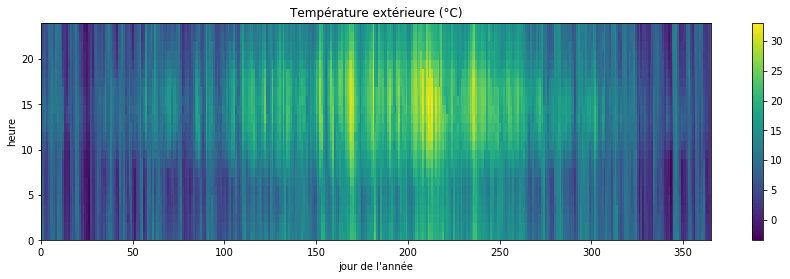

In [9]:
# == Heat map == 
T_ext_grid = np.array([h.value for h in datazone.col(1, start_rowx=1)]).reshape(-1, 24).T

plt.figure(figsize=(15, 4))
plt.pcolormesh(T_ext_grid, shading='flat'); plt.colorbar();
plt.title("Température extérieure (°C)")
plt.xlabel("jour de l'année"); plt.ylabel('heure');

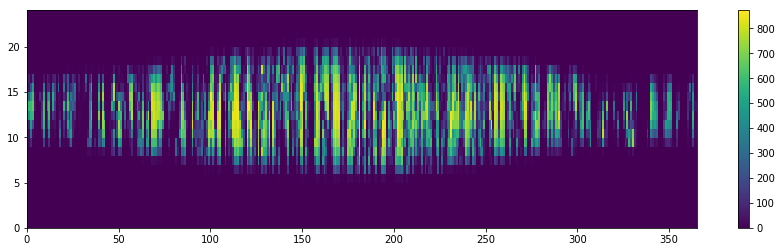

In [10]:
plt.figure(figsize=(15, 4))
plt.pcolormesh(dirN_grid, shading='flat'); plt.colorbar();

In [13]:
list(data.keys())

['Htsmd',
 'te0',
 'we0',
 'dirN',
 'diff',
 'Teciel',
 'Vent',
 'Teau',
 'Gamma',
 'Psi']

In [50]:
columns_to_export = ['Htsmd', 'te0', 'dirN']
dataarray = np.stack([data[c] for c in columns_to_export], axis=-1)

In [53]:
filename = f'{zone_climatique}_{villes[zone_climatique]}.csv'
np.savetxt(filename, dataarray, fmt='%.18e', delimiter=';', header=';'.join(columns_to_export))

# Correlation

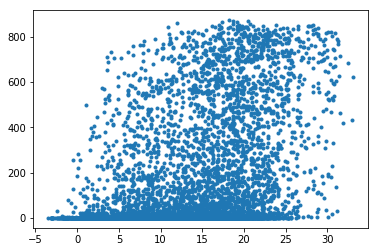

In [55]:
plt.plot(data['te0'], data['dirN'], '.')

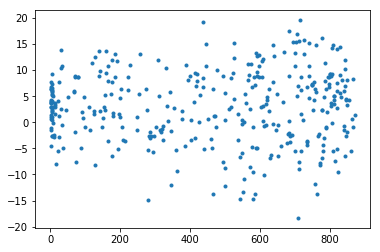

In [60]:
plt.plot(dirN_grid.max(axis=0), T_ciel_grid.mean(axis=0), '.')

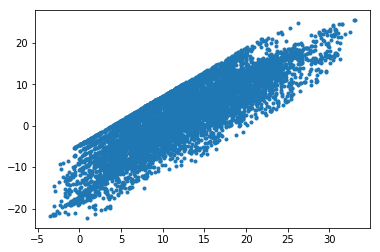

In [61]:
plt.plot(data['te0'], data['Teciel'], '.')

https://physics.stackexchange.com/a/153947/105894
https://github.com/xdze2/thermique_appart/blob/master/Model02_tuile.ipynb

It's much closer to 273 K than 2.73 K. The answer depends on the surface temperature, the humidity, the temperature gradient through the atmosphere, and what exactly you mean by "the temperature of the clear night sky".

The Swinbank formula provides an ad hoc expression for the power radiated by the night sky. A modified version of this formula from Goforth et al. is $$P_{\text{thermal}} = (1+KC^2)8.78\times 10^{-13}\,T^{5.852}\,{RH}^{0.07195}$$ where

    $K$ is a scale factor based on cloud height, ranging from 0.34 for very low clouds to 0.06 for very high clouds,
    $C$ is the fraction of the sky covered by clouds,
    $T$ is the surface temperature, in kelvins,
    $RH$ is the surface relative humidity, as a percentage (e.g., $RH$ would be 25 in the case of 25% relative humidity), and
    $P_{\text{thermal}}$ is the night sky radiation, in watts per square meter.

This can be converted to an effective temperature via the Stefan-Boltzmann law. Now the question arises as to whether you are asking about the effective black body temperature or effective gray body temperature of the night sky. In the first case the Stefan-Boltzmann law yields $T = (P/\sigma)^{1/4}$. Taking emissivity into account yields $T = (P/(\epsilon \sigma))^{1/4}$, where $\epsilon\approx 0.74$ is the emissivity of the atmosphere.

A couple of examples:

    A cool clear night in the desert, with a temperature of 5°C and a relative humidity of 5%. The modified Swinbank formula yields a flux of 198 w/m2, which in turn corresponds to a black body temperature of -29.9°C or a gray body temperature of -10.9°C.

    A warm clear night in the countryside, with a temperature of 15°C and a relative humidity of 25%. The modified Swinbank formula in this case yields a flux of 274 w/m2, which in turn corresponds to a black body temperature of -9.5°C or a gray body temperature of 11.1°C.
